In [36]:
!pip install py3Dmol
!pip install rdkit
!pip install pyscf
!pip install botorch

<a target="_blank" href="https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/w2024/Course_Notes/Week%208/BayesOpt_H2O_PES.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [37]:
import numpy as np
import pyscf
from pyscf import dft

import py3Dmol
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, rdDetermineBonds, MolFromXYZBlock
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

# Introduction to Bayesian Optimization using [BOTorch](https://botorch.org/) #

There are many libraries that are capable of doing Bayesian Optimization (BO). <br>
In this tutorial, we will learn how to use [BOTorch](https://botorch.org/), a BO library built in Torch and GPyTorch.


## Generate a water molecule dataset ##
The molecule of water has two internal variables,
1. O-H distance
2. H-O-H angle

We will use PySCF to generate DFT-level data for different water geometries using the Z-matrix notation.


In [38]:
def get_z_matrix(angle, dist, n_atoms = 3):
    xyz = []

    mol = pyscf.gto.Mole()
    mol.atom = '''
      O
      H  1  	1.2
      H  1  %.3f  2 %.3f
    '''%(dist,angle)
    mol.unit = 'Angstrom'
    mol.build()
    for i in range(n_atoms):
        xyzi = mol.atom_coord(i).tolist()
        xyzi = [mol.atom_symbol(i)] + xyzi
        xyz.append(xyzi)

    xyz_str = '%s\n Generated by PySCF\n'%(n_atoms)
    for xyzi in xyz:
        print(xyzi)
        xyzi_str = '%s     %.4f     %.4f     %.4f\n'%(xyzi[0],xyzi[1],xyzi[2],xyzi[3])
        xyz_str += xyzi_str
    return xyz_str

In [39]:
def energy_water_calculation(angle,dist):
    mol = pyscf.gto.Mole()
    mol.atom = '''
      O
      H  1  	1.2
      H  1  %.3f  2 %.3f
    '''%(dist,angle)
    mol.unit = 'Angstrom'
    mol.basis = 'sto-3g' #basis set level
    mol.build()
    rks_h2o = dft.RKS(mol)
    rks_h2o.xc = 'b3lyp' # dft model
    energy =rks_h2o.kernel()

    return energy, get_z_matrix(angle,dist)

In [40]:
# generate grid for the water geometries

angle_list = np.linspace(40., 140., 12)
dist_list = np.linspace(0.8, 1.6, 12)


In [41]:
xyz_all = []
pes = []

X,Y = np.meshgrid(angle_list,dist_list)
for angle,dist in zip(X.flatten(),Y.flatten()):
      # pes_i, xyz_i = scan_pes(angle,dist)
      pes_i, xyz_i = energy_water_calculation(angle,dist)
      pes.append(pes_i)
      xyz_all.append(xyz_i)

converged SCF energy = -75.0517131313823
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 1.1580913573918619, 0.0, 0.971754030857107]
converged SCF energy = -75.1097434593317
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.9900041367028667, 0.0, 1.1425293422332625]
converged SCF energy = -75.1529030090334
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.7970453152894023, 0.0, 1.284601204237322]
converged SCF energy = -75.1843957384958
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.584062544372849, 0.0, 1.3944003846863617]
converged SCF energy = -75.2060584856619
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.356406531332137, 0.0, 1.4691684290701847]
converged SCF energy = -75.2191398307139
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.1197966153588499, 0.0, 1.5070269604427533]
converged SCF energy = -75.2246525492307
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -0.1197966153

Text(0, 0.5, 'H-O Bond distance')

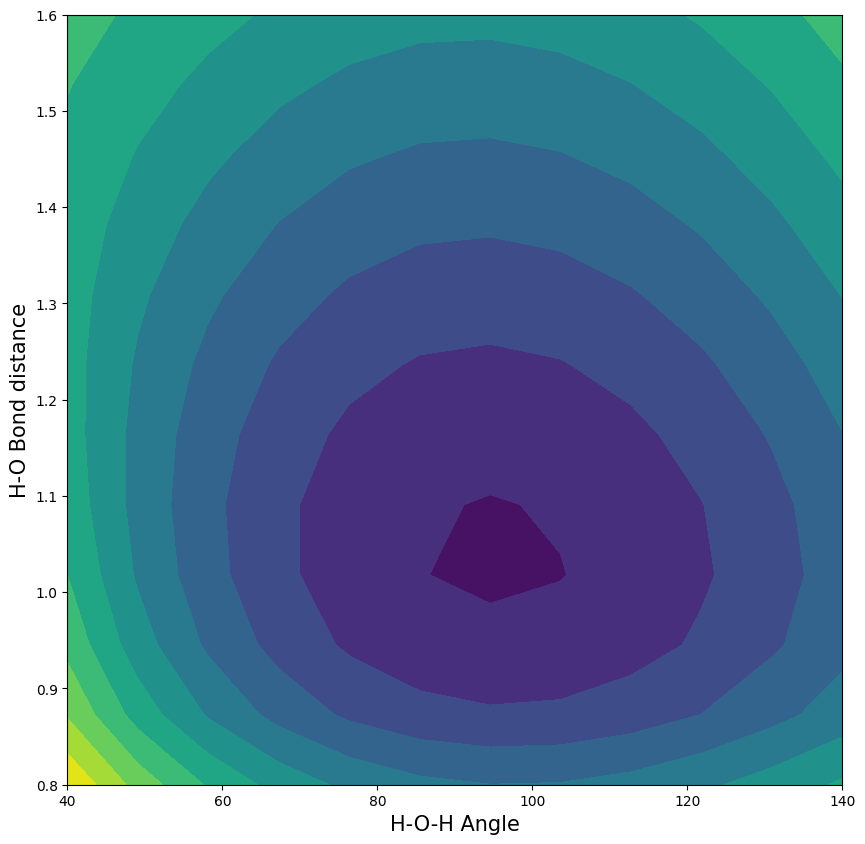

In [42]:
import matplotlib
import matplotlib.pyplot as plt

D = {'Energy':np.asarray(pes),
     'X':np.column_stack((X.flatten(),Y.flatten()))}

# X,Y = np.meshgrid(angle_list,dist_list)
Z = np.asarray(pes).reshape(X.shape)

plt.figure(figsize=(10,10))
plt.contourf(X,Y,Z,levels=10)
plt.xlabel('H-O-H Angle',fontsize=15)
plt.ylabel('H-O Bond distance',fontsize=15)

###  BOTorch for geometry optimization ###

The goal is to find the geometry of water that has the lowest energy,

$$
{\cal M}^* = \arg\min_{{\cal M}} E({\cal M}),
$$
where ${\cal M}$ is a molecular geometry and $E(\cdot)$ is the quantum chemistry methodology to compute the energy.

For this example, ${\cal M} = [r^{OH}, \theta^{HOH}]$.

Tutorial based on [link](https://botorch.org/docs/getting_started)

In [43]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

In [44]:
# utility functions
def scale_data(y,bool_min=True):
    mu = np.mean(y)
    std = np.std(y)
    if bool_min:
      z = -1
    else:
      z = 1

    def scale(x):
      x = (x-mu)/std
      return z*x
    return scale


The geometry represeantations of our water system is,
$$
X =  \begin{bmatrix}
 {\cal M}_0 \\
 \vdots\\
 {\cal M}_N
\end{bmatrix} = \begin{bmatrix}
[r^{OH}, \theta^{HOH}]_0 \\
 \vdots\\
 [r^{OH}, \theta^{HOH}]_N
\end{bmatrix}
$$

In [45]:
Xtot = D['X'] #all geometries
ytot = D['Energy']

# f_scale = scale_data(ytot)
# ytot = f_scale(ytot)


# random initial geometries
Ninit = 5
i0 = np.random.randint(0,Xtot.shape[0], Ninit)
X_train = torch.tensor(Xtot[i0])
y_train = torch.tensor(ytot[i0]).unsqueeze(-1)

print(X_train.shape,y_train.shape)

torch.Size([5, 2]) torch.Size([5, 1])


### Step 1: Define a Gaussian Process for BO ###

In [46]:
# define a GP for Bayesian Optimization

gp = SingleTaskGP(X_train, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2385], dtype=torch.float64), std = tensor([0.0391], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


### Step 2: Define an Aquisition function ($\alpha$) ###

**UpperConfidentBound**
$$
\alpha({\cal M}) = \mu({\cal M}) + \kappa \sigma({\cal M}),
$$
where $\mu({\cal M})$ is the mean of the GP, and $\sigma({\cal M})$ is the standard deviation.

In [47]:
# Construct an aquisition function

UCB = UpperConfidenceBound(gp, beta=0.1)

### Step 3: Optimize the Aquisition function ###

$$
{\cal M}^* = \arg\max_{{\cal M}} \alpha({\cal M}),
$$
where ${\cal M}^*$ is the proposed point by the acquisition function.

In [48]:
# Optimize the acquisition function

bounds = torch.tensor([[20.,0.5],[180,2.]])
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
print(candidate)

tensor([[77.3090,  0.9776]])


Text(0, 0.5, 'H-O Bond distance')

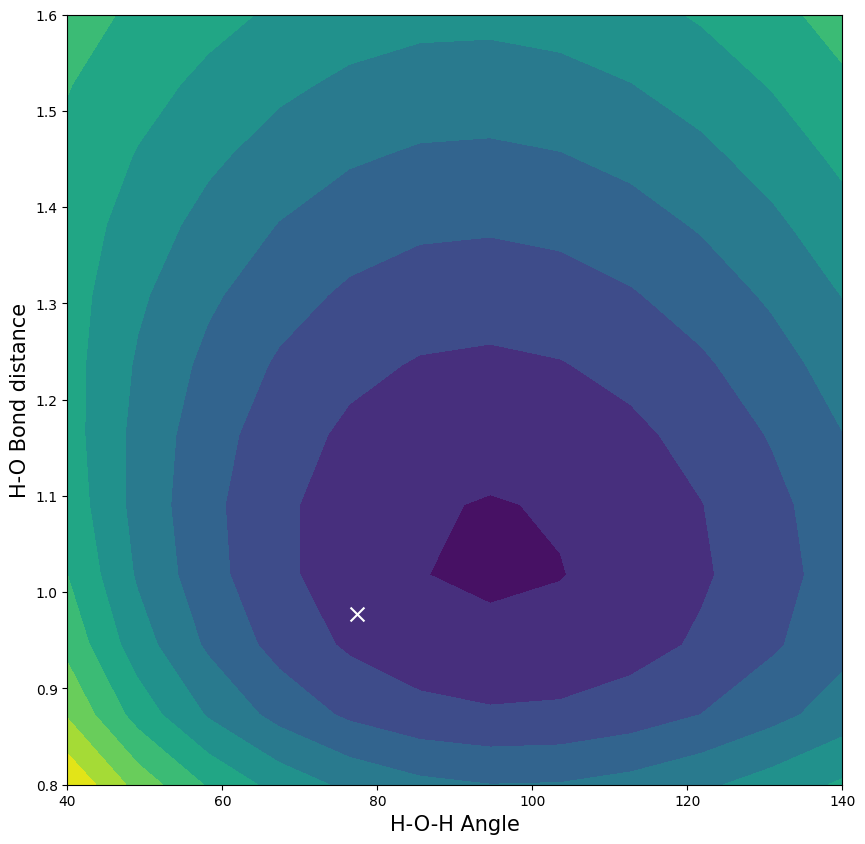

In [49]:
# X,Y = np.meshgrid(angle_list,dist_list)
Z = np.asarray(pes).reshape(X.shape)

plt.figure(figsize=(10,10))
plt.contourf(X,Y,Z,levels=10)
x_candidate = candidate.detach()
plt.scatter(x_candidate[:,0], x_candidate[:,1], marker='x',c='w',s=100)
plt.xlabel('H-O-H Angle',fontsize=15)
plt.ylabel('H-O Bond distance',fontsize=15)

## BO algorithm ##

In [50]:
candidates = []
X_train_bo = X_train
y_train_bo = y_train
for i in range(20):
    # step 1
    gp = SingleTaskGP(X_train_bo, y_train_bo)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);

    # step 2 and 3
    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidates.append(candidate.detach().numpy()[0])


    xi = candidate.detach().numpy()[0]
    angle = xi[0]
    dist = xi[1]
    y_energy0,_ = energy_water_calculation(angle,dist)
    # y_energy = f_scale(np.array([y_energy0]))
    y_energy = y_energy0

    X_train_bo = torch.vstack((X_train_bo,candidate))
    y_train_bo = torch.vstack((y_train_bo,torch.tensor([y_energy])))
    print(i,xi,y_energy0)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2385], dtype=torch.float64), std = tensor([0.0391], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2879565169618
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.4764973777796358, 0.0, 2.0058715963298814]
0 [76.63675    1.0907873] -75.2879565169618


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2468], dtype=torch.float64), std = tensor([0.0403], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1325572115798
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.9621088754870843, 0.0, 3.359033567774603]
1 [74.017334   1.8491092] -75.13255721157984


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2305], dtype=torch.float64), std = tensor([0.0568], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1656587448829
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.2236110304611183, 0.0, 2.9212688059179284]
2 [112.727264    1.6761003] -75.16565874488286


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2224], dtype=torch.float64), std = tensor([0.0573], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1963786478941
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.6797512095870375, 0.0, 2.8782424396132704]
3 [76.712265   1.5654416] -75.19637864789406


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2195], dtype=torch.float64), std = tensor([0.0543], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1465759244128
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.7948056443726648, 0.0, 3.2820742983023483]
4 [76.38749    1.7866982] -75.1465759244128


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2122], dtype=torch.float64), std = tensor([0.0562], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2322186108703
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.6444484011511322, 0.0, 2.579562205047588]
5 [75.9734     1.4073409] -75.2322186108703


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2140], dtype=torch.float64), std = tensor([0.0536], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1136679245967
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.4866199946275758, 0.0, 3.309733277114246]
6 [114.18784     1.9199505] -75.11366792459668


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2056], dtype=torch.float64), std = tensor([0.0588], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2373305025228
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.3140259631705298, 0.0, 1.1952943772338744]
7 [137.70862      0.94041276] -75.23733050252277


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2081], dtype=torch.float64), std = tensor([0.0569], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2352270106341
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.3380797559198598, 0.0, 1.174042986834449]
8 [138.73602     0.9416496] -75.23522701063408


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2100], dtype=torch.float64), std = tensor([0.0552], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1545498613553
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.6601199028379127, 0.0, 3.2501093295700176]
9 [78.51857    1.7550174] -75.15454986135528


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2063], dtype=torch.float64), std = tensor([0.0551], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2370094110174
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.5035409535667213, 0.0, 2.595330066932981]
10 [79.0202     1.3989902] -75.23700941101744


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2082], dtype=torch.float64), std = tensor([0.0538], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1275343544098
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.3533393404284628, 0.0, 3.231617380295372]
11 [112.72331     1.8538581] -75.12753435440982


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2035], dtype=torch.float64), std = tensor([0.0556], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2419148893227
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.432703076839253, 0.0, 1.2667464263358623]
12 [138.5178      1.0122794] -75.24191488932271


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2056], dtype=torch.float64), std = tensor([0.0547], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2388511343894
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.4797345505192183, 0.0, 1.2528207759414636]
13 [139.7473      1.0260744] -75.23885113438942


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2074], dtype=torch.float64), std = tensor([0.0537], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1656578058614
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.2236620160337472, 0.0, 2.9212474494317493]
14 [112.72759     1.6761146] -75.16565780586141


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2053], dtype=torch.float64), std = tensor([0.0531], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1342319926016
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -2.3816017250784207, 0.0, 1.908432282933248]
15 [141.29353     1.6151344] -75.13423199260158


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2019], dtype=torch.float64), std = tensor([0.0540], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.2120332191483
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.8065321944559556, 0.0, 1.435385413904431]
16 [141.53067     1.2208489] -75.21203321914827


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2024], dtype=torch.float64), std = tensor([0.0528], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.1656587448829
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', -1.2236110304611183, 0.0, 2.9212688059179284]
17 [112.72728     1.6760912] -75.16565874488288


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2008], dtype=torch.float64), std = tensor([0.0521], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.288903467371
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.45022454872089906, 0.0, 1.881975219436724]
18 [76.54641    1.0239731] -75.28890346737101


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-75.2044], dtype=torch.float64), std = tensor([0.0541], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


converged SCF energy = -75.0824654705203
['O', 0.0, 0.0, 0.0]
['H', 2.267671349478074, 0.0, 0.0]
['H', 0.3342886241980784, 0.0, 1.2876831832663704]
19 [75.446526    0.70410806] -75.08246547052032


Text(0, 0.5, 'Energy of the candidate point')

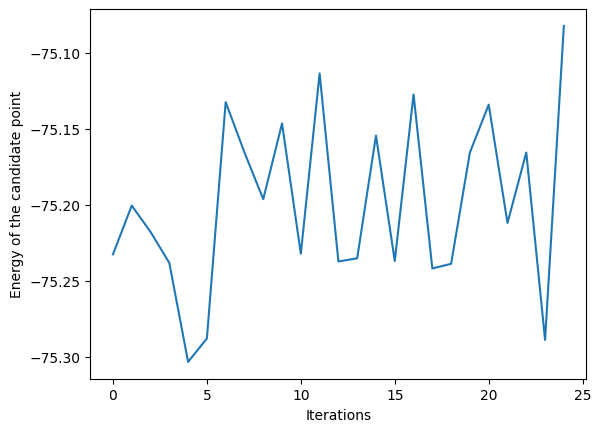

In [51]:
plt.plot(np.arange(y_train_bo.detach().shape[0]),y_train_bo.detach())
plt.xlabel('Iterations')
plt.ylabel('Energy of the candidate point')

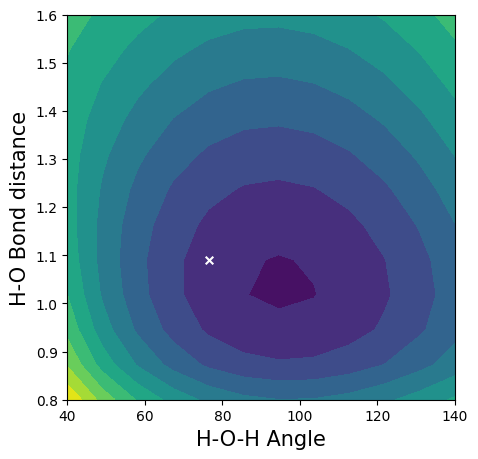

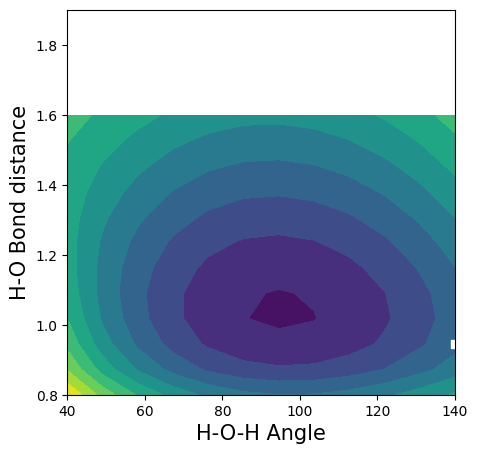

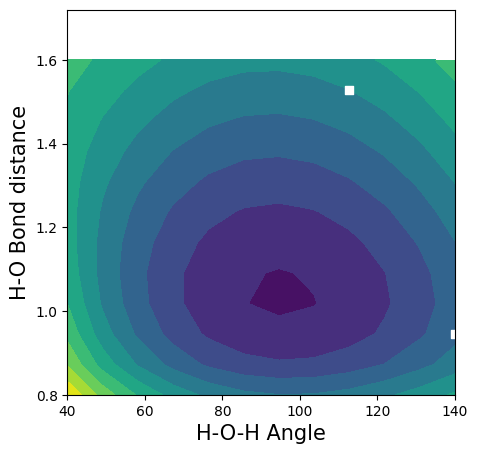

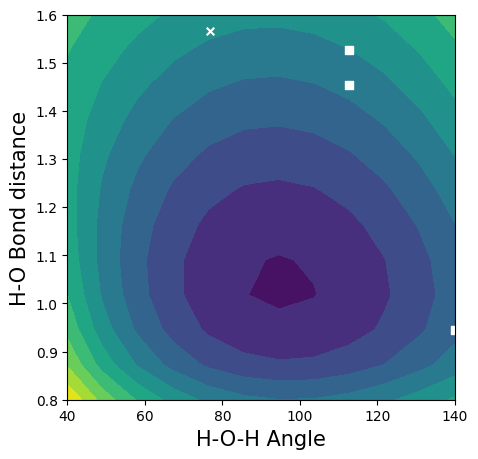

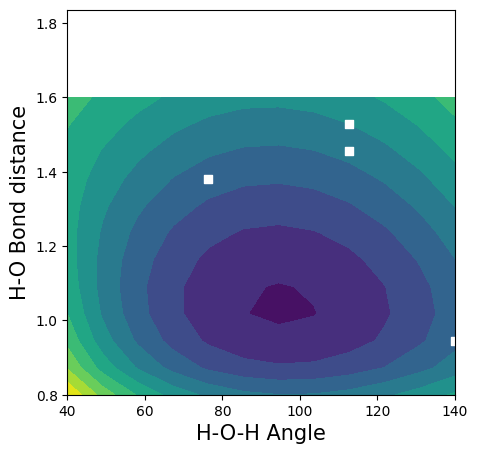

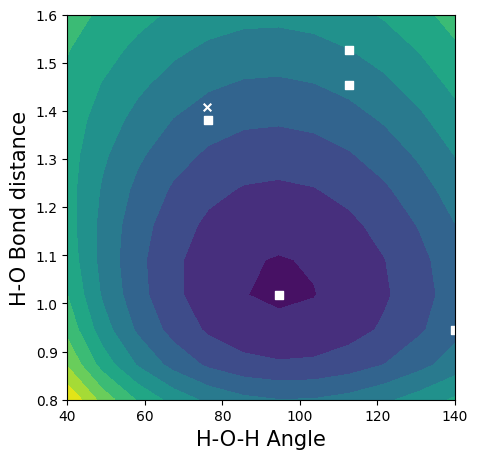

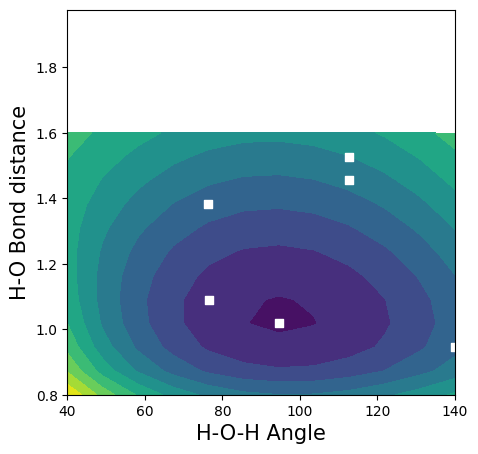

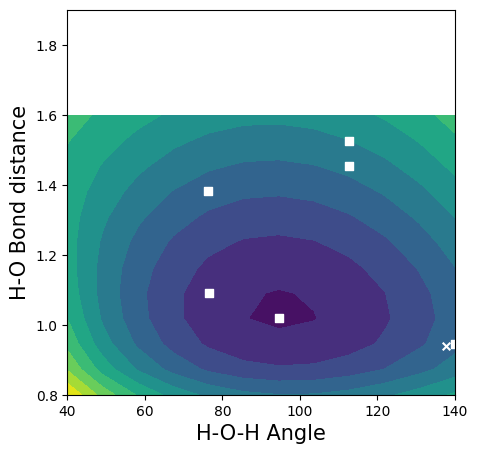

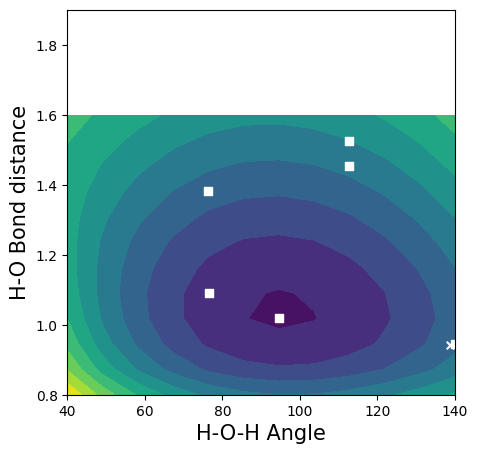

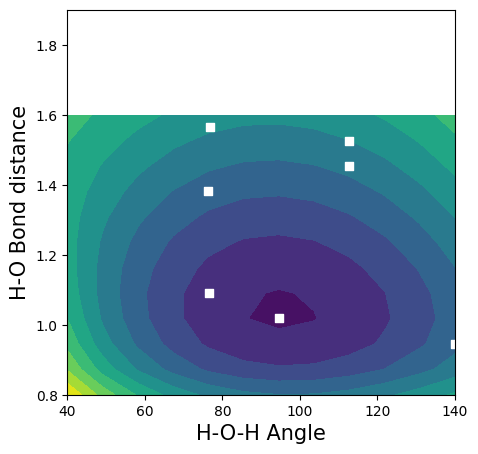

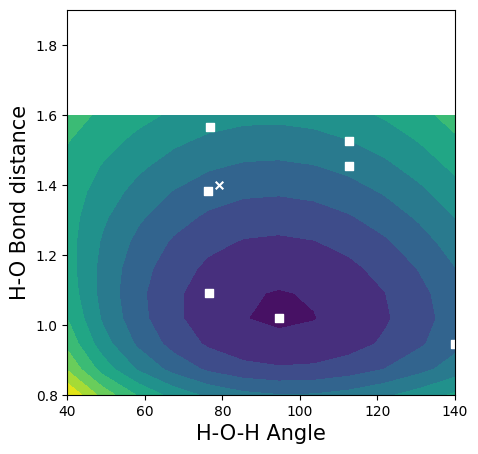

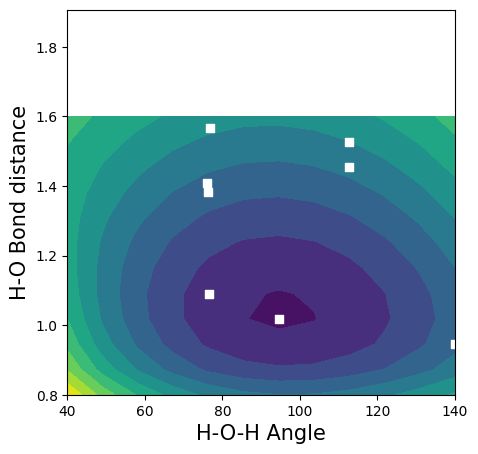

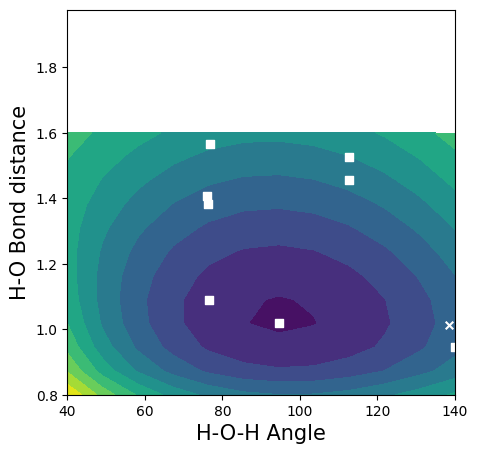

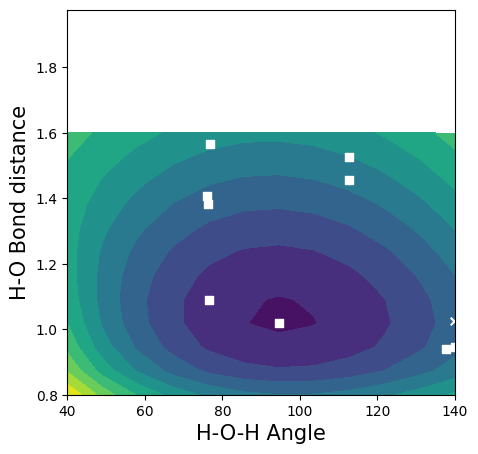

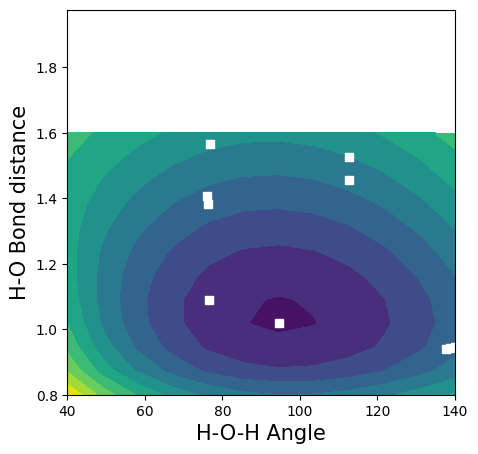

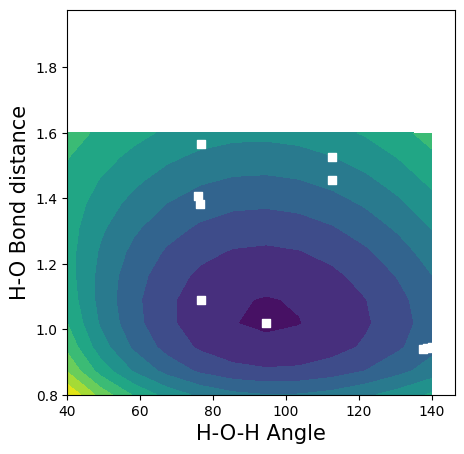

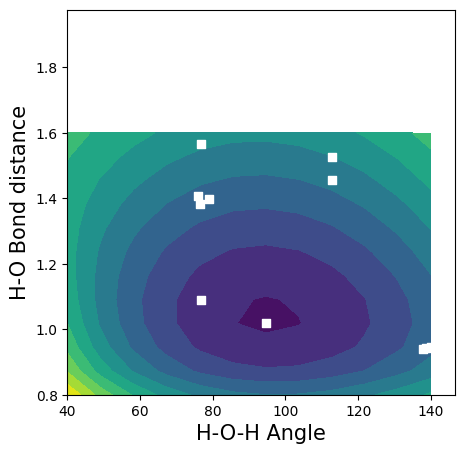

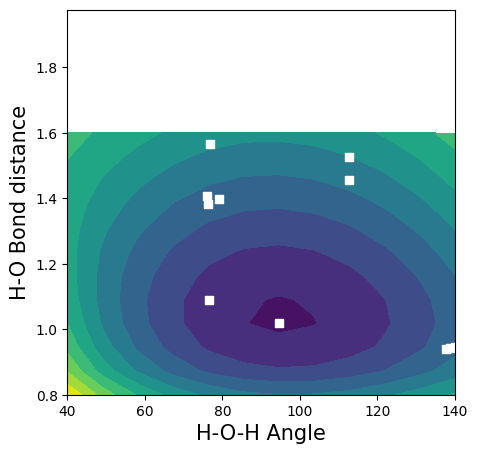

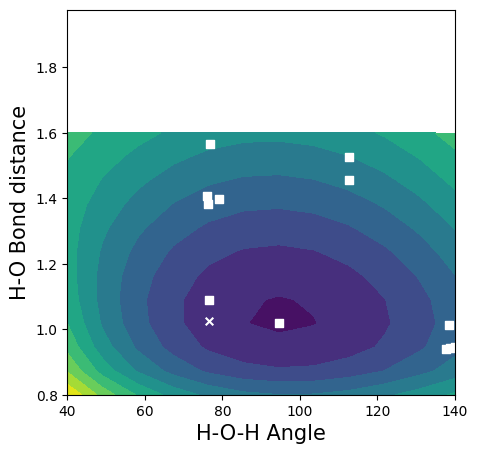

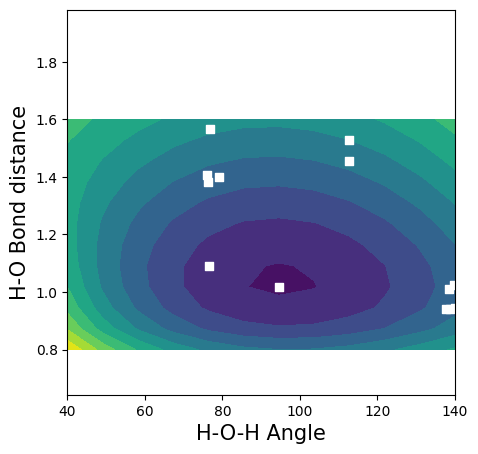

In [52]:
candidates = np.asarray(candidates)
for i,x in enumerate(candidates):
    plt.figure(figsize=(5,5))
    plt.clf()
    plt.contourf(X,Y,Z,levels=10)
    plt.scatter(X_train_bo.detach().numpy()[:i,0],X_train_bo.detach().numpy()[:i,1],color='w',s=30,marker='s')
    plt.scatter(candidates[i,0],candidates[i,1],color='w',s=30,marker='x')
    plt.xlabel('H-O-H Angle',fontsize=15)
    plt.ylabel('H-O Bond distance',fontsize=15)

### Plot a molecule ###

In [53]:
def draw_with_spheres(xyz):
    raw_mol = Chem.MolFromXYZBlock(xyz)
    conn_mol = Chem.Mol(raw_mol)
    rdDetermineBonds.DetermineConnectivity(conn_mol)

    v = py3Dmol.view(width=400, height=400)
    IPythonConsole.addMolToView(conn_mol, v)
    v.zoomTo()
    v.setStyle({'sphere': {'radius': 0.35}, 'stick': {'radius': 0.1}})
    v.show()

In [54]:
xyz = '''3
* (null), Energy   -1000.0000000
H     0.00000     0.7554     -0.47116
H     0.00000    -0.75545     -0.4711
O     0.00000     0.00000     0.11779
'''

draw_with_spheres(xyz)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol